# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импортируем необходимые библиотеки.

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Сохраним данные из файла CSV в переменную data и посмотрим на общую информацию о датасете.

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В данных нет пропусков, а типы столбцов приведены к численным. Данные столбца *is_ultra* представленны целочисленным типом.

In [5]:
data['is_ultra'].value_counts(normalize=True) 

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Среди значений *is_ultra* 69.5% - 0 (тариф пользователя Смарт) и 30.5% - 1 (тариф пользователя Ультра).

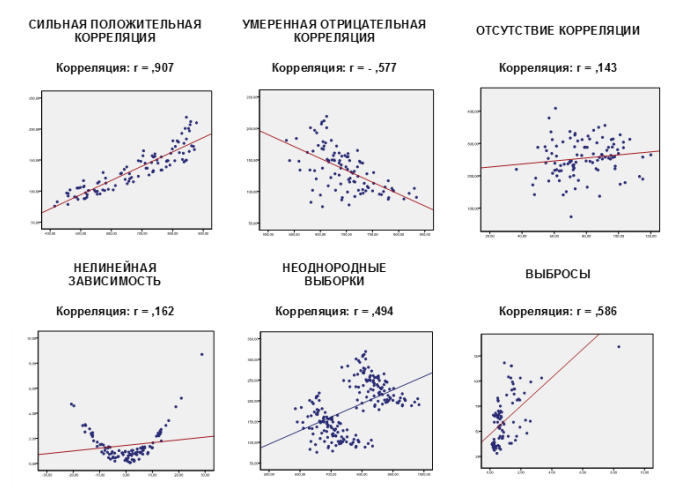

Построим матрицу рассеяния и проверим зависимости признаков друг от друга.

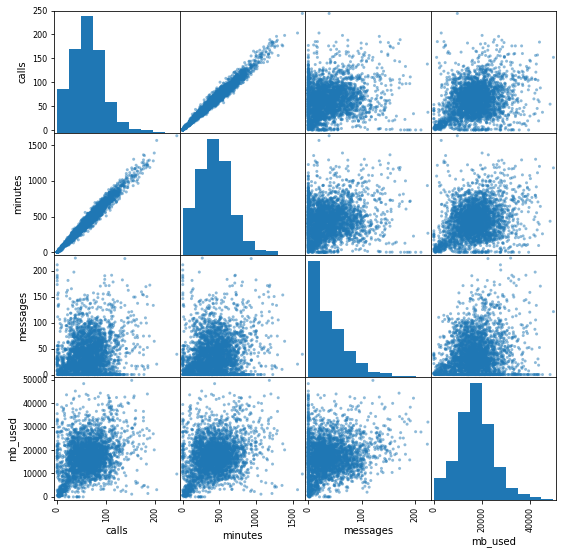

In [6]:
_ = pd.plotting.scatter_matrix(data.drop('is_ultra', axis=1), figsize=(9, 9))

In [7]:
data[['minutes', 'calls']].corr()

,minutes,calls
minutes,1.000000,0.982083
calls,0.982083,1.000000


Между значениями минут и количества звонков существует сильная зависимость, коэффициент корреляции 0.98. В тарифах оператора существуют лимиты на минуты разговора, поэтому обучать модели будем на данных о минутах, а данные о количестве звонков уберем из выборки.

## Разбейте данные на выборки

Исходя из задачи за целевой признак возьмем значение *is_ultra*. Сохраним столбец *is_ultra*  в переменной target, а остальные признаки в переменной features. Не забудем убрать данные о количестве звонков.

In [8]:
features = data.drop(['is_ultra', 'calls'], axis=1)
target = data['is_ultra']

Разобьем датасет на тренировочную (train), тестовую (test) и валидационную (valid) выборки в соотношении 6-2-2.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

Провери размеры полученных выборок.

In [10]:
print('Shapes\nTraining set: {}\nTesting set: {}\nValidation set: {}'
      .format(features_train.shape, features_test.shape, features_valid.shape))

Shapes
Training set: (1928, 3)
Testing set: (643, 3)
Validation set: (643, 3)


Данные подготовленны для обучения и проверки моделей.

## Исследуйте модели

Будем обучать модели по трем алгоритмам обучения: решающее дерево (DecisionTreeClassifier), случайный лес (RandomForestClassifier) и логистическая регрессия (LogisticRegression). В словаре *models_accuracy* будем записывать результаты метрики Accuracy для лучшей модели.

In [11]:
models_accuracy = {'DTC':0, 'RFC':0, 'LR':0}

Для алгоритма Decision Tree будем варьировать гиперпараметры: критерий выбора, минимальное число объектов во внутреннем узле, минимальное число объектов в листовом узле (нижнем) и глубина дерева. Выберем наилучшие гиперпараметры по Accuracy модели.

In [12]:
best_model = None
tree_result = 0

for crit in ['gini', 'entropy']:
    for mss in range(2, 21, 4):
        for msl in range(1, 20, 4):
            for depth in range(1, 11):
                model = DecisionTreeClassifier(
                    random_state=12345, max_depth=depth, min_samples_split=mss, min_samples_leaf=msl, criterion=crit)
                model.fit(features_train, target_train)
                result = model.score(features_valid, target_valid)

                if result > models_accuracy['DTC']:
                    best_tree = model
                    models_accuracy['DTC'] = result
                    best_depth = depth
                    best_min_samples_split = mss
                    best_min_samples_leaf = msl
                    best_crit = crit
        
print('DecisionTreeClassifier\nAccuracy лучшей модели: {:.4f}\nГлубина дерева: {}\
      \nМинимум объектов в узле для разделения: {}\nМинимум объектов в нижних узлах: {}\nКритерий: {}'
      .format(models_accuracy['DTC'], best_depth, best_min_samples_split, best_min_samples_leaf, best_crit))

DecisionTreeClassifier
Accuracy лучшей модели: 0.7947
Глубина дерева: 5      
Минимум объектов в узле для разделения: 2
Минимум объектов в нижних узлах: 9
Критерий: entropy


Для алгоритма Random Forest будем варьировать гиперпараметры: количество оценщиков и глубину деревьев.

In [13]:
best_forest = None
best_result = 0

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)

        if result > models_accuracy['RFC']:
            best_forest = model
            models_accuracy['RFC'] = result
            best_est = est
            best_depth = depth

print('RandomForestClassifier\nAccuracy лучшей модели: {:.4f}\nГлубина деревьев: {}\nКоличество оценщиков: {}'
      .format(models_accuracy['RFC'], best_depth, best_est))

RandomForestClassifier
Accuracy лучшей модели: 0.7994
Глубина деревьев: 8
Количество оценщиков: 20


Для алгоритма логистической регрессии будем варьировать алгорит оптимизации.

In [14]:
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_result = 0
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for solver in solver_list:
        model = LogisticRegression(random_state=12345, solver=solver)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        
        print('{:.4f} - {}'.format(result, solver))
        
        if result > models_accuracy['LR']:
            best_logreg = model
            models_accuracy['LR'] = result
            best_solver = solver

print('\nLogisticRegression\nAccuracy лучшей модели: {:.4f}\nSolver: {}'.format(models_accuracy['LR'], best_solver))

0.7558 - newton-cg
0.7076 - lbfgs
0.7076 - liblinear
0.7061 - sag
0.7061 - saga

LogisticRegression
Accuracy лучшей модели: 0.7558
Solver: newton-cg


In [15]:
print('Accuracy:', pd.Series(models_accuracy).sort_values(ascending=False), sep='\n')

Accuracy:
RFC    0.799378
DTC    0.794712
LR     0.755832
dtype: float64


Наибольший показатель Accuracy был получен у модели с алгоритмом обучения Random Forest - 0.799378. Гиперпараметры это модели выбраны: глубина деревьев - 8, количество оценщиков - 20. Сохраним эту модель в переменную *model*.

In [16]:
model = best_forest

## Проверьте модель на тестовой выборке

Мы определили гиперпараметры алгоритма обучения. Теперь объединим обучающую и валидационную выборки и обучим на них модель Random Forest с выбранными гиперпараметрами. Проверим точность предсказаний модели на тестовой выборке.

In [22]:
features_train_valid = pd.concat([features_train, features_valid], axis=0)
target_train_valid = pd.concat([target_train, target_valid], axis=0)

model.fit(features_train_valid, target_train_valid)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)

print('Accuracy на тестовой выборке: {:.4f}'.format(result))

Accuracy на тестовой выборке: 0.8087


Accuracy обученной модели 0.8087, что больше заданной 0.75.

## (бонус) Проверьте модели на адекватность

Проверим обученную модель на всем датасете. Разделим датасет на два по тарифу пользователя (*is_ultra*) и посчитаем точность прогноза на этих выборках.

In [20]:
smart = features[data['is_ultra']==0]
ultra = features[data['is_ultra']==1]
accuracy = []

In [23]:
for _features in [smart, ultra, features]:
    _target = target[_features.index]

    _predictions = model.predict(_features)
    accuracy.append(accuracy_score(_target, _predictions))

print('Accuracy предсказания тарифа:\nСмарт: {:.4f}\nУльтра: {:.4f}\nПо всей выборке: {:.4f}'.format(*accuracy))

Accuracy предсказания тарифа:
Смарт: 0.9731
Ультра: 0.5624
По всей выборке: 0.8472


Модель хорошо научилась предсказывать пользователей тарифа Смарт (97% точности), тогда как предсказания пользователей тарифа Ультра оказались не такими точными (56%). В целом по выборке точность обученной модели 84.7%.

Доля пользователей тарифа Ультра всего около 30%. Для увеличения точности предсказания этого тарифа нужно увеличить обучающую выборку.